In [4]:
import numpy as np
import cv2
import random
import pandas as pd


import matplotlib.pyplot as plt
from seaborn import load_dataset
from scipy.spatial import distance

In [5]:
imagenReferencia = cv2.imread('/home/miguel/Descargas/Proyecto Tesis/Imagenes Originales Gris/Baboon_gray.png')
imagenReferenciaGris = cv2.cvtColor(imagenReferencia, cv2.COLOR_RGB2GRAY)
imagenRuido = cv2.imread('/home/miguel/Descargas/Proyecto Tesis/Baboon/Baboon_gray_512_512_variance_225.png')
imagenRuidoGris = cv2.cvtColor(imagenRuido, cv2.COLOR_RGB2GRAY)
areaBusqueda = 21
tamañoParche = 8


#Función que retorna la lista con los cortes de la imagen de cacuerdo al parche propuesto; posición 0 = Alto, posición 1  = Ancho
def cortarImagen(imagen,areaBus):
    posicionesAltoAncho = [] 
    altoImagen = imagen.shape[0]
    anchoImagen = imagen.shape[1]
    posicionAlto = random.randint(0,altoImagen)
    posicionAncho = random.randint(0,anchoImagen)
    if (areaBus + posicionAlto) > altoImagen:
        posicionAlto = altoImagen - areaBus
    if (areaBus + posicionAncho) > anchoImagen:
        posicionAncho = anchoImagen - areaBus
    posicionesAltoAncho.append(posicionAlto)
    posicionesAltoAncho.append(posicionAncho)
    return posicionesAltoAncho

# Algoritmo de búsqueda exhaustiva

In [62]:
# imgAct: Imagen actual puede ser ruidosa (imagen de la cual se adquiere la plantilla)
# areaBus: Área de búsqueda 
# tamParche: tamaño del parche (parche dentro del área de búsqueda)

def algoritmoBusquedaExhaustiva(imgAct,imgRuido,areaBus,tamParche): 
#     imagenActualFiltro = transformadaCosenoDiscreta(imgAct)
#     imagenRuidoFiltro = transformadaCosenoDiscreta(imgRuido)
   # imagenActualFiltro = cv2.GaussianBlur(imgAct,(5,5),0)
    #imagenRuidoFiltro = cv2.GaussianBlur(imgRuido,(5,5),0)
    
    listaAreaBusqueda = cortarImagen(imgAct,areaBus)
    posicionAltoArea = listaAreaBusqueda[0]
    posicionAnchoArea = listaAreaBusqueda[1]
    areaBuscar = imgAct[posicionAltoArea:posicionAltoArea+areaBus, posicionAnchoArea: posicionAnchoArea+areaBus]
    listaParcheBuscar = cortarImagen(areaBuscar,tamParche)
    posicionAltoParche = listaParcheBuscar[0]
    posicionAnchoParche = listaParcheBuscar[1]
    posicionAltoImagenActual = posicionAltoArea + posicionAltoParche
    posicionAnchoImagenActual = posicionAnchoArea + posicionAnchoParche
    imagenMain = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenMain = transformadaCosenoDiscreta(imagenMain)
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoArea,posicionAltoArea+areaBus-tamParche+1):
        for n in range(posicionAnchoArea,posicionAnchoArea+areaBus-tamParche+1):
            imagenComparar = imgRuido[m:m+tamParche, n: n+tamParche]
            imagenComparar = transformadaCosenoDiscreta(imagenComparar)
            ssd=0
            for rx_Pache in range (0,tamParche):
                for ry_Pache in range (0,tamParche):
                    resta = int(imagenMain[rx_Pache,ry_Pache])-int(imagenComparar[rx_Pache,ry_Pache])
                    ssd += resta**2
#                     ssd += np.sum(np.power((imagenMain[rx_Parche_int,ry_Parche_int]-imagenReferencia[rx_Parche_int,ry_Parche_int]),2))
            dh1 = dh1.append({'ssd': ssd, 'coordenada_x':m, 'coordenada_y':n}, ignore_index=True)
    #print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ssd = dh1.sort_values('ssd',ascending=True)
    by_ssd = by_ssd.reset_index(drop=True)
    #by_ssd.head()
    posicionAltoImagenComparar = by_ssd['coordenada_x'][0]
    posicionAnchoImagenComparar = by_ssd['coordenada_y'][0]
    
    #print(by_ssd)
    return posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenComparar,posicionAnchoImagenComparar
    
        
    

In [63]:
imagen = algoritmoBusquedaExhaustiva(imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
# plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
# plt.show()
# cv2.imwrite('8x8.png', imagen)

In [66]:
pxy_pref_ABE = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
for i in range(0,500):
    posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBusquedaExhaustiva(imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
    pxy_pref_ABE = pxy_pref_ABE.append({'coordenada_x': posicionAltoImagenActual, 'coordenada_y':posicionAnchoImagenActual
                                , 'referencia_x':posicionAltoImagenReferencia,'referencia_y':posicionAnchoImagenReferencia}, ignore_index=True)
    
pxy_pref_ABE

,coordenada_x,coordenada_y,referencia_x,referencia_y
0,377,504,378,503
1,210,101,197,95
2,95,225,98,221
3,296,385,292,386
4,54,365,54,356
...,...,...,...,...
495,329,395,316,392
496,46,158,41,161
497,267,63,261,63
498,49,432,47,429


In [67]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref_ABE)-1):
    if pxy_pref_ABE['coordenada_x'][i] == pxy_pref_ABE['referencia_x'][i] and pxy_pref_ABE['coordenada_y'][i] == pxy_pref_ABE['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref_ABE)-1)
miu
    

0.3186372745490982

lena.png
Sin ruido da 1

Efectivo/lena_gray_512_512_variance_25_Efectivo.png:
Con la TDC en la imágen grande
0.9595959595
0.9696969696969697

Con la TDC en la imágen pequeña r²
0.31313131313131315
0.2828282828282828

lena/lena_gray_512_512_variance_25.png
0.32323232323232326
0.31313131313131315

Efectivo/lena_gray_512_512_variance_100_Efectivo.png:


Efectivo/lena_gray_512_512_variance_225_Efectivo.png:

Efectivo/lena_gray_512_512_variance_400_Efectivo.png:


In [742]:


a = np.zeros([2,2],dtype=np.uint8)
a[0][0] = 157
a[0][1] = 128
a[1][0] = 159
a[1][1] = 165

print(a)

b = np.zeros([2,2],dtype=np.uint8)
b[0][0] = 157
b[0][1] = 130
b[1][0] = 159
b[1][1] = 185
print(b)

suma = (np.sum(b-a)**2)
suma

[[157 128]
 [159 165]]
[[157 130]
 [159 185]]


484.0

Posteriormente hay que hacer una segunda fase, para el ABJ hay que calcular la distancia euclideana para los primeros 8 parches para el de algoritmoBJTCD hay que hacer rw=5 de los 8 primeros.

# Algoritmo de Búsqueda Jerárquica

In [70]:
def algoritmoBusquedaJerarquica(imgAct,imgRuido,areaBus,tamParche):   
#     imgActBlur = cv2.GaussianBlur(imgAct,(5,5),0)
#     imgRuidoBlur = cv2.GaussianBlur(imgRuido,(5,5),0)
#     imgActBlur = transformadaCosenoDiscreta(imgAct)
#     imgRuidoBlur = transformadaCosenoDiscreta(imgRuido)
    
    listaAreaBusqueda = cortarImagen(imgAct,areaBus)
    posicionAltoArea = listaAreaBusqueda[0]
    posicionAnchoArea = listaAreaBusqueda[1]
    areaBuscar = imgAct[posicionAltoArea:posicionAltoArea+areaBus, posicionAnchoArea: posicionAnchoArea+areaBus]
    
    listaParcheBuscar = cortarImagen(areaBuscar,tamParche)
    posicionAltoParche = listaParcheBuscar[0]
    posicionAnchoParche = listaParcheBuscar[1]
    
    posicionAltoImagenActual = posicionAltoArea + posicionAltoParche
    posicionAnchoImagenActual = posicionAnchoArea + posicionAnchoParche
    imagenActualTemplate = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenActualTemplate = transformadaCosenoDiscreta(imagenActualTemplate)
#     imagenActualTemplate = cv2.GaussianBlur(imagenActual,(3,3),0) # Esta parte se inserta dado que el artículo dice que se agrega un filtro suavizado
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoArea,posicionAltoArea+areaBus-tamParche+1):
        for n in range(posicionAnchoArea,posicionAnchoArea+areaBus-tamParche+1):
            imagenReferenciaBlur = imgRuido[m:m+tamParche, n: n+tamParche]
#             imagenReferenciaBlur = cv2.GaussianBlur(imagenReferencia,(3,3),0)
            imagenReferenciaBlur = transformadaCosenoDiscreta(imagenReferenciaBlur)
            lenParche=int(tamParche/2)
            ssd=0
            for rx_Pache in range (0,lenParche):
                for ry_Pache in range (0,lenParche):
                    rx_Parche_int = int(2*(rx_Pache))
                    ry_Parche_int = int(2*(ry_Pache))
#                     resta = int(imagenActualTemplate[rx_Parche_int,ry_Parche_int])-int(imagenReferenciaBlur[rx_Parche_int,ry_Parche_int])
#                     ssd += resta**2
                    ssd += np.sum(np.power((imagenActualTemplate[rx_Parche_int,ry_Parche_int]-imagenReferenciaBlur[rx_Parche_int,ry_Parche_int]),2))
            dh1 = dh1.append({'ssd': ssd, 'coordenada_x':m, 'coordenada_y':n}, ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ascending_ssd = dh1.sort_values('ssd',ascending=True)
    by_ascending_ssd = by_ascending_ssd.reset_index(drop=True)
    by_ascending_ssd = by_ascending_ssd.astype(int)

    #by_ssd.head()
#     print(by_ascending_ssd)
    
    ##Aquí comienza la segunda etapa
    dhFefinitive = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for iteraLista in range(0,8):
        Alto_x = by_ascending_ssd['coordenada_x'][iteraLista]
        Alto_y = by_ascending_ssd['coordenada_y'][iteraLista]
        imagenReferenciaDosBlur = imgRuido[Alto_x:Alto_x+tamParche, Alto_y: Alto_y+tamParche]
#         imagenReferenciaDosBlur = cv2.GaussianBlur(imagenReferenciaDos,(3,3),0)
        imagenReferenciaDosBlur = transformadaCosenoDiscreta(imagenReferenciaDosBlur)
        ssd=0
        for i in range (0,tamParche):
            for j in range (0,tamParche):
                resta = int(imagenActualTemplate[i,j])-int(imagenReferenciaDosBlur[i,j])
                ssd += resta**2
#                 ssd += np.sum(np.power((imagenActualTemplate[i,j]-imagenReferenciaDos[i,j]),2))
        dhFefinitive = dhFefinitive.append({'ssd': ssd, 'coordenada_x':Alto_x, 'coordenada_y':Alto_y}, ignore_index=True)
    by_ascending_dhFefinitive = dhFefinitive.sort_values('ssd', ascending=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.reset_index(drop=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.astype(int)

#     print(by_ascending_dhFefinitive)
    posicionAltoImagenReferencia = by_ascending_dhFefinitive['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ascending_dhFefinitive['coordenada_y'][0]
#     plt.imshow(cv2.cvtColor(imagenActualTemplate, cv2.COLOR_BGR2RGB))
#     plt.show()
    return posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenReferencia,posicionAnchoImagenReferencia #imagenActual

In [71]:
posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBusquedaJerarquica(imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)

In [5]:
pxy_pref = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
for i in range(0,500):
    posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBusquedaJerarquica(imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
    pxy_pref = pxy_pref.append({'coordenada_x': posicionAltoImagenActual, 'coordenada_y':posicionAnchoImagenActual
                                , 'referencia_x':posicionAltoImagenReferencia,'referencia_y':posicionAnchoImagenReferencia}, ignore_index=True)
    
pxy_pref
# plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
# plt.show()
#print(imagen)

NameError: name 'algoritmoBusquedaJerarquica' is not defined

In [73]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref)-1):
    if pxy_pref['coordenada_x'][i] == pxy_pref['referencia_x'][i] and pxy_pref['coordenada_y'][i] == pxy_pref['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref)-1)
miu
    
    

0.21643286573146292

0.007814407814407814
Resultados con TDC 

lena.png
Sin ruido da 1

Efectivo/lena_gray_512_512_variance_25_Efectivo.png:
Con la TDC en la imágen grande
0.8697674418604651

Con la TDC en la imágen pequeña r²
0.21643286573146292

lena/lena_gray_512_512_variance_25.png
0.26262626262626265

Efectivo/lena_gray_512_512_variance_100_Efectivo.png:
0.5050505050505051
0.3939393939393939

Efectivo/lena_gray_512_512_variance_225_Efectivo.png:
0.31313131313131315
0.25252525252525254

Efectivo/lena_gray_512_512_variance_400_Efectivo.png:
0.2222222222222222
0.2828282828282828

# Transformada de coseno discreta

In [6]:
#imagenGrises = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)
def transformadaCosenoDiscreta(imagenGrises):
    imgFlotante= imagenGrises.astype('float')
    C_temp = np.zeros(imagenGrises.shape)
    dst = np.zeros(imagenGrises.shape)

    m = imagenGrises.shape[0]
    n = imagenGrises.shape[1]

    N = n
    C_temp[0, :] = 1 * np.sqrt(1/N)

    for indiceAltura in range (1,m):
        for indiceAncho in range(n):
            C_temp[indiceAltura, indiceAncho] = np.cos(np.pi * indiceAltura * (2*indiceAncho+1) / (2 * N ))* np.sqrt(2 / N )


    dst = np.dot(C_temp, imgFlotante)
    dst = np.dot(dst, np.transpose(C_temp))
    # dst1 = np.log(abs(dst))  #Valor absoluto
    return dst



# Algoritmo de Búsqueda Jerárquica en el dominio de la Transformada de coseno discreta

In [4]:
def algoritmoBJTCD(imgAct,imgRuido,areaBus,tamParche): 
#     imagenActualFiltro = transformadaCosenoDiscreta(imgAct)
#     imagenRuidoFiltro = transformadaCosenoDiscreta(imgRuido)
#     dst1=np.log(abs(imagenActualFiltro))
#     dst1=dst1.astype('uint8') * 255
    listaAreaBusqueda = cortarImagen(imgAct,areaBus)
    posicionAltoArea = listaAreaBusqueda[0]
    posicionAnchoArea = listaAreaBusqueda[1]
    areaBuscar = imgAct[posicionAltoArea:posicionAltoArea+areaBus, posicionAnchoArea: posicionAnchoArea+areaBus]
    
    listaParcheBuscar = cortarImagen(areaBuscar,tamParche)
    posicionAltoParche = listaParcheBuscar[0]
    posicionAnchoParche = listaParcheBuscar[1]
    
    posicionAltoImagenActual = posicionAltoArea + posicionAltoParche
    posicionAnchoImagenActual = posicionAnchoArea + posicionAnchoParche
    imagenActualTCD = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenActualTCD = transformadaCosenoDiscreta(imagenActualTCD)
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoArea,posicionAltoArea+areaBus-tamParche+1):
        for n in range(posicionAnchoArea,posicionAnchoArea+areaBus-tamParche+1):
            imagenReferenciaTCD = imgRuido[m:m+tamParche, n: n+tamParche]
            imagenReferenciaTCD = transformadaCosenoDiscreta(imagenReferenciaTCD)
            lenParche=4 
            ssd=0
            for rx_Pache in range (0,lenParche):
                for ry_Pache in range (0,lenParche):
                    resta = int(imagenActualTCD[rx_Pache,ry_Pache])-int(imagenReferenciaTCD[rx_Pache,ry_Pache])
                    ssd += resta**2
#                     ssd += np.sum(np.power((imagenActualTCD[rx_Pache,ry_Pache]-imagenReferenciaTCD[rx_Pache,ry_Pache]),2))
            dh1 = dh1.append({'ssd': ssd, 'coordenada_x':m, 'coordenada_y':n}, ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ascending_ssd = dh1.sort_values('ssd',ascending=True)
    by_ascending_ssd = by_ascending_ssd.reset_index(drop=True)
    by_ascending_ssd = by_ascending_ssd.astype(int)
    #by_ssd.head()
#     print(by_ascending_ssd)
    
    ##Aquí comienza la segunda etapa
    dhFefinitive = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for iteraLista in range(0,8):
        Alto_x = by_ascending_ssd['coordenada_x'][iteraLista]
        Alto_y = by_ascending_ssd['coordenada_y'][iteraLista]
        imagenReferenciaDosTCD = imgRuido[Alto_x:Alto_x+tamParche, Alto_y: Alto_y+tamParche]
        imagenReferenciaDosTCD = transformadaCosenoDiscreta(imagenReferenciaDosTCD)
        ssd=0
        lenParche = 5
        for i in range (0,lenParche):
            for j in range (0,lenParche):
                resta = int(imagenActualTCD[i,j])-int(imagenReferenciaDosTCD[i,j])
                ssd += resta**2
#                 ssd += np.sum(np.power((imagenActualTCD[i,j]-imagenReferenciaDosTCD[i,j]),2))
        dhFefinitive = dhFefinitive.append({'ssd': ssd, 'coordenada_x':Alto_x, 'coordenada_y':Alto_y}, ignore_index=True)
    by_ascending_dhFefinitive = dhFefinitive.sort_values('ssd', ascending=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.reset_index(drop=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.astype(int)
#     print(by_ascending_dhFefinitive)
    posicionAltoImagenReferencia = by_ascending_dhFefinitive['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ascending_dhFefinitive['coordenada_y'][0]
#     plt.imshow(cv2.cvtColor(imgAct, cv2.COLOR_BGR2RGB))
#     plt.show()
    return posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenReferencia,posicionAnchoImagenReferencia

In [76]:
pxy_pref = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
for i in range(0,500):
    posicionAltoImagenActual,posicionAnchoImagenActual,posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBJTCD(imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
    pxy_pref = pxy_pref.append({'coordenada_x': posicionAltoImagenActual, 'coordenada_y':posicionAnchoImagenActual
                                , 'referencia_x':posicionAltoImagenReferencia,'referencia_y':posicionAnchoImagenReferencia}, ignore_index=True)
    
pxy_pref

,coordenada_x,coordenada_y,referencia_x,referencia_y
0,97,234,97,234
1,449,30,451,29
2,504,377,503,377
3,503,99,503,99
4,87,136,84,149
...,...,...,...,...
495,369,30,372,26
496,466,191,466,190
497,54,187,54,179
498,40,317,27,321


In [77]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref)-1):
    if pxy_pref['coordenada_x'][i] == pxy_pref['referencia_x'][i] and pxy_pref['coordenada_y'][i] == pxy_pref['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref)-1)
miu

0.19839679358717435

0.2235 realizando el filtro a la imagen 8x8

lena.png
Sin ruido da 1

Resultados Efectivo/lena_gray_512_512_variance_25_Efectivo.png
Con la TDC en la imágen grande
0.7575091575091575 realizando el filtro a toda la imagen
0.7272727272727273
Con la TDC en la imágen pequeña r²
0.19839679358717435


lena/lena_gray_512_512_variance_25.png
0.15151515151515152

Resultados Efectivo/lena_gray_512_512_variance_100_Efectivo.png
0.4444444444444444
0.41414141414141414

Resultados Efectivo/lena_gray_512_512_variance_225_Efectivo.png
0.3333333333333333
0.1919191919191919

Resultados Efectivo/lena_gray_512_512_variance_400_Efectivo.png
0.1919191919191919
0.16161616161616163

<div style="text-align: center; margin: 50px">
<h2>Filtros pasa-bajos</h2>
</div>

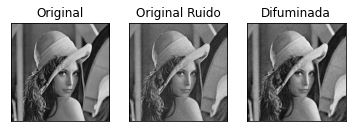

In [806]:
imagenOriginal = cv2.imread('lena.png')
imagenOriginalGris = cv2.cvtColor(imagenOriginal, cv2.COLOR_RGB2GRAY)
imagenSuavizadoPromedio = cv2.imread('gaussian100.png')
imagenPromedioGris = cv2.cvtColor(imagenSuavizadoPromedio, cv2.COLOR_RGB2GRAY)

#blur = cv2.blur(imagenPromedioGris,(3,3)) #Filtro promedio
#blur = cv2.GaussianBlur(imagenPromedioGris,(5,5),0) #Filtro gaussiano
blur = cv2.medianBlur(imagenPromedioGris,5) #Filtro de mediana

plt.subplot(131),plt.imshow(imagenOriginalGris, 'gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(imagenPromedioGris, 'gray'),plt.title('Original Ruido')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(blur, 'gray'),plt.title('Difuminada')
plt.xticks([]), plt.yticks([])
plt.show()

#https://unipython.com/suavizando-imagenes-con-opencv/

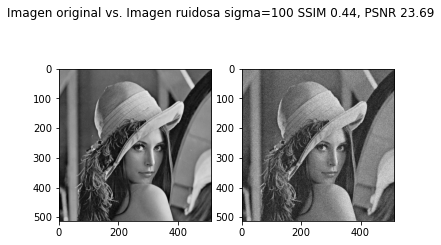

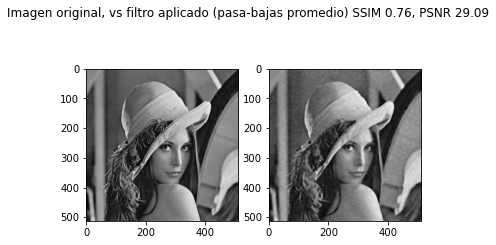

In [807]:
from skimage.metrics import structural_similarity as ssim # Structural Similarity Index Measure
from skimage.metrics import peak_signal_noise_ratio as psnr #Peak Signal Noise Ratio

def img_comparison(image_A,image_B,title):
    s = ssim(image_A,image_B)
    p = psnr(image_A,image_B)
    plt.suptitle(title+" SSIM %.2f" %(s) +", PSNR %.2f" %(p) )

    a = plt.subplot(121)
    plt.imshow(image_A,cmap='gray')

    b = plt.subplot(122)
    plt.imshow(image_B,cmap='gray')

    plt.show()

img_comparison(imagenOriginalGris,imagenPromedioGris,"Imagen original vs. Imagen ruidosa sigma=100")
print("\n")
img_comparison(imagenOriginalGris,blur,"Imagen original, vs filtro aplicado (pasa-bajas promedio)")
print("\n")


Imagen original vs imagen ruidosa sigma = 100
SSIM = 0.44
PSNR = 23.69
## Filtro pasa-bajas promedio 3,3
Imagen original vs filtro pasa-bajas promedio
SSIM = 0.75
PSNR = 30.01
## Filtro gaussiano 5,5
Imagen original vs filtro gaussiano
SSIM = 0.79
PSNR = 30.32
## Filtro mediana
Imagen original vs filtro promedio
SSIM = 0.76
PSNR = 29.09


In [ ]:
#print(imagen)
#print(transformadaCosenoDiscreta(imagen))

# # Para la transformada inversa del coseno discreta
# img_recor = np.dot(np.transpose(C_temp) , dst)
# img_recor1 = np.dot(img_recor, C_temp)


#Transformada del coseno discreta python (Cv2)

# img_dct = cv2.dct(imgFlotante)
# img_dct_log = np.log(abs(img_dct))
# img_recor2 = cv2.idct(img_dct)

# plt.subplot(231)
# plt.imshow(imagenGrises, 'gray')
# plt.title('imagen original')
# plt.xticks([]), plt.yticks([])

# plt.subplot(232)
# plt.imshow(dst1)
# plt.title('DCT1')
# plt.xticks([]), plt.yticks([])

# plt.subplot(233)
# plt.imshow(img_recor1,'gray')
# plt.title('IDCT1')
# plt.xticks([]), plt.yticks([])

# plt.subplot(234)
# plt.imshow(imagenGrises,'gray')
# plt.title('imagen original')
# plt.xticks([]), plt.yticks([])

# plt.subplot(235)
# plt.imshow(img_dct_log)
# plt.title('DCT2(cv2_dct)')
# plt.xticks([]), plt.yticks([])

# plt.subplot(236)
# plt.imshow(img_recor2,'gray')
# plt.title('DCT2(cv2_idct)')
# plt.xticks([]), plt.yticks([])

# Se ha actualizado el archivo Block_Matching_Random_Test

# Se ha actualizado el archivo Block_Matching_Random_Test

In [7]:
def algoritmoBJTCD(posicionAltoImagenActual,posicionAnchoImagenActual,imgAct,imgRuido,areaBus,tamParche):
#     imagenActualFiltro = transformadaCosenoDiscreta(imgAct)
#     imagenRuidoFiltro = transformadaCosenoDiscreta(imgRuido)

    imagenActual = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenActualTCD = transformadaCosenoDiscreta(imagenActual)
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoImagenActual,posicionAltoImagenActual+areaBus-tamParche+1):
        for n in range(posicionAnchoImagenActual,posicionAnchoImagenActual+areaBus-tamParche+1):
            imagenReferencia = imgRuido[m:m+tamParche, n: n+tamParche]
            imagenReferenciaTCD = transformadaCosenoDiscreta(imagenReferencia)
            lenParche=4 
            ssd=0
            for rx_Pache in range (0,lenParche):
                for ry_Pache in range (0,lenParche):
                    resta = int(imagenActualTCD[rx_Pache,ry_Pache])-int(imagenReferenciaTCD[rx_Pache,ry_Pache])
                    ssd += resta**2
#                     ssd += np.sum(np.power((imagenActualTCD[rx_Pache,ry_Pache]-imagenReferenciaTCD[rx_Pache,ry_Pache]),2))
            dh1 = dh1.append({'ssd': ssd, 'coordenada_x':m, 'coordenada_y':n}, ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ascending_ssd = dh1.sort_values('ssd',ascending=True)
    by_ascending_ssd = by_ascending_ssd.reset_index(drop=True)
    by_ascending_ssd = by_ascending_ssd.astype(int)
    #by_ssd.head()
#     print(by_ascending_ssd)
    
    ##Aquí comienza la segunda etapa
    dhFefinitive = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for iteraLista in range(0,8):
        Alto_x = by_ascending_ssd['coordenada_x'][iteraLista]
        Alto_y = by_ascending_ssd['coordenada_y'][iteraLista]
        imagenReferenciaDos = imgRuido[Alto_x:Alto_x+tamParche, Alto_y: Alto_y+tamParche]
        imagenReferenciaDosTCD = transformadaCosenoDiscreta(imagenReferenciaDos)
        ssd=0
        lenParche = 5
        for i in range (0,lenParche):
            for j in range (0,lenParche):
                resta = int(imagenActualTCD[i,j])-int(imagenReferenciaDosTCD[i,j])
                ssd += resta**2
#                 ssd += np.sum(np.power((imagenActualTCD[i,j]-imagenReferenciaDosTCD[i,j]),2))
        dhFefinitive = dhFefinitive.append({'ssd': ssd, 'coordenada_x':Alto_x, 'coordenada_y':Alto_y}, ignore_index=True)
    by_ascending_dhFefinitive = dhFefinitive.sort_values('ssd', ascending=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.reset_index(drop=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.astype(int)
#     print(by_ascending_dhFefinitive)
    posicionAltoImagenReferencia = by_ascending_dhFefinitive['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ascending_dhFefinitive['coordenada_y'][0]
    
    return posicionAltoImagenReferencia,posicionAnchoImagenReferencia

In [8]:
pxy_pref_BJTCD = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
altoImagen = imagenReferenciaGris.shape[0]
anchoImagen = imagenReferenciaGris.shape[1]

for posicionAlto in range(0,altoImagen-areaBusqueda): # altoImagen-areaBusqueda
    for posicionAncho in range(0,250): # anchoImagen-areaBusqueda
        posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBJTCD(posicionAlto,posicionAncho,imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
        pxy_pref_BJTCD = pxy_pref_BJTCD.append({'coordenada_x': posicionAlto, 'coordenada_y':posicionAncho, 'referencia_x':posicionAltoImagenReferencia,'referencia_y':posicionAnchoImagenReferencia}, ignore_index=True)
    
    
pxy_pref_BJTCD
# imagen = algoritmoBJTCD(imagenActual,areaBusqueda,tamañoParche)


,coordenada_x,coordenada_y,referencia_x,referencia_y
0,0,0,0,0
1,0,1,0,1
2,0,2,0,2
3,0,3,0,3
4,0,4,0,4
...,...,...,...,...
122745,490,245,490,245
122746,490,246,492,246
122747,490,247,491,247
122748,490,248,491,248


In [9]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref_BJTCD)-1):
    if pxy_pref_BJTCD['coordenada_x'][i] == pxy_pref_BJTCD['referencia_x'][i] and pxy_pref_BJTCD['coordenada_y'][i] == pxy_pref_BJTCD['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref_BJTCD)-1)
miu
    

0.5083707402911632

Efectivo/lena_gray_512_512_variance_25_Efectivo.png:
Con la TDC en la imágen grande
0.7935332669653227
Con la TDC en la imágen pequeña r²
0.352166686939473


lena/lena_gray_512_512_variance_25.png:
Con la TDC en la imágen pequeña r²
0.286126414005445

lena/lena_gray_512_512_variance_400.png:
Con la TDC en la imágen pequeña r²
0.108866822122107

In [7]:
# imgAct: Imagen actual puede ser ruidosa (imagen de la cual se adquiere la plantilla)
# areaBus: Área de búsqueda 
# tamParche: tamaño del parche (parche dentro del área de búsqueda)

def algoritmoBusquedaExhaustiva(posicionAltoImagenActual,posicionAnchoImagenActual,imgAct,imgRuido,areaBus,tamParche):   
    
    imagenActual = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoImagenActual,posicionAltoImagenActual+areaBus-tamParche+1):
        for n in range(posicionAnchoImagenActual,posicionAnchoImagenActual+areaBus-tamParche+1):
            imagenReferencia = imgRuido[m:m+tamParche, n: n+tamParche]
            ssd=0
            for rx_Pache in range (0,tamParche):
                for ry_Pache in range (0,tamParche):
                    resta = int(imagenActual[rx_Pache,ry_Pache])-int(imagenReferencia[rx_Pache,ry_Pache])
                    ssd += resta**2
#                     ssd += np.sum(np.power((imagenActual[rx_Pache,ry_Pache]-imagenReferencia[rx_Pache,ry_Pache]),2))
            dh1 = dh1.append({'ssd': ssd, 'coordenada_x':m, 'coordenada_y':n}, ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ssd = dh1.sort_values('ssd',ascending=True)
    by_ssd = by_ssd.reset_index(drop=True)
#     by_ssd.head()
    posicionAltoImagenReferencia = by_ssd['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ssd['coordenada_y'][0]
    
#     print(by_ssd)
    return posicionAltoImagenReferencia,posicionAnchoImagenReferencia
    
        

In [11]:
pxy_pref_ABE = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
altoImagen = imagenReferenciaGris.shape[0]
anchoImagen = imagenReferenciaGris.shape[1]

for posicionAlto in range(0,altoImagen-areaBusqueda): # altoImagen-areaBusqueda
    for posicionAncho in range(0,anchoImagen-areaBusqueda): # anchoImagen-areaBusqueda
        posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBusquedaExhaustiva(posicionAlto,posicionAncho,imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
        pxy_pref_ABE = pxy_pref_ABE.append({'coordenada_x': posicionAlto, 'coordenada_y':posicionAncho, 'referencia_x':posicionAltoImagenReferencia,'referencia_y':posicionAnchoImagenReferencia}, ignore_index=True)
    
    
        
pxy_pref_ABE

,coordenada_x,coordenada_y,referencia_x,referencia_y
0,0,0,0,0
1,0,1,0,1
2,0,2,0,2
3,0,3,0,3
4,0,4,0,4
...,...,...,...,...
241076,490,486,497,492
241077,490,487,502,491
241078,490,488,497,494
241079,490,489,499,490


In [12]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref_ABE)-1):
    if pxy_pref_ABE['coordenada_x'][i] == pxy_pref_ABE['referencia_x'][i] and pxy_pref_ABE['coordenada_y'][i] == pxy_pref_ABE['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref_ABE)-1)
miu
    

0.7213704994192799

lena/lena_gray_512_512_variance_25.png:
0.32918118466898955

lena/lena_gray_512_512_variance_400.png:
0.11053592168574747